# Image Denoising with U-Net & PyTorch Implementation of a CNN to remove Gaussian noise from STL10 images.

In [1]:
skip_training = False

<h3>Import all the necessary libraries </h3>


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.datasets import STL10
from torch.utils.data import random_split, DataLoader

import warnings
warnings.filterwarnings("ignore")

<h3> Select the device to run the model.</h3>


In [4]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<h3> Download the dataset and create a dataloader to loop through mini batches of data. </h3>

In [ ]:
dataset_path = './dataset_image_denoising'

In [7]:
dataset = STL10(root=dataset_path, split='train', transform=transforms.ToTensor(), download=True)
train_size = 4000
test_size = 1000

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

100%|██████████| 2.64G/2.64G [01:15<00:00, 34.8MB/s]


<h3> Adding Gaussian Noise to Images </h3>

In [8]:
def add_gaussian_noise(images, mean=0, std=0.1):
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

In [9]:
def imshow(img, ax, title):
    np_img = img.numpy()
    ax.imshow(np.transpose(np_img, (1, 2, 0)))
    ax.set_title(title)
    ax.axis('off')

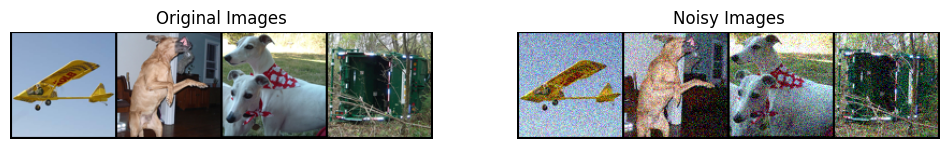

In [10]:
# Get a batch of training data
images, _ = next(iter(train_loader))
noisy_images = add_gaussian_noise(images)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
imshow(torchvision.utils.make_grid(images[:4]), axes[0], 'Original Images')
imshow(torchvision.utils.make_grid(noisy_images[:4]), axes[1], 'Noisy Images')
plt.show()

<h3>Define the U-Net Model Class. </h3>

**Useful links:**

- [Conv2D in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [ReLU in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [MaxPool2D in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
- [Transpose Conv2D in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)
- [Sigmoid in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)


In [ ]:
class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # can be reused in the forward as it has no parameters.

        self.enc2=None
        self.enc3= None
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoding path
        self.upconv1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2=None
        self.dec2= None
        self.dec3=None

        
        self.upconv2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.dec2=nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec3=nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size=3, padding=1)
        )



    def forward(self, x):
        """
        Parameters:
            x: input images of shape (batch_size, 3, 96, 96)
        Returns:
            denoised images of shape (batch_size, 3, 96, 96)
        """
        output1=self.enc1(x)
        output2=self.enc2(self.pool(output1))
        output3=self.enc3(self.pool(output2))
        output4=self.upconv1(output3)
        output5=self.dec1(torch.cat((output4, output2), dim=1))
        output6=self.upconv2(output5)
        output7=self.dec2(torch.cat((output6, output1), dim=1))
        output8=self.dec3(output7)
        return torch.sigmoid(output8)




<h3>Define the loss function and optimizer.</h3>

   - [Refer: MSE loss in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)

   - [Refer: Adam optimizer in PyTorch](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)




In [ ]:
def loss_and_optimizer(model):
    loss = nn.MSELoss()
    optim = torch.optim.Adam(model.parameters(),lr=0.001)
    return (loss,optim)


In [35]:
model = MiniUNet()
criterion, optimizer = loss_and_optimizer(model)

model = model.to(device)
criterion = criterion.to(device)

<h3>Training loop.</h3>


In [ ]:
# Training loop

def train(model, optimizer, criterion, train_loader, num_epochs=10, verbose=True):
   
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = []                                 # Append the loss of every iteration to the epoch loss
        for i, (images, _) in enumerate(train_loader):

            images = images.to(device)                  # Move the input to 'device' (CPU or GPU)
            noisy_images = add_gaussian_noise(images)   # Add Gaussian noise to simulate noisy images

           
            optimizer.zero_grad()
            output=model(noisy_images)
            loss=criterion(output,images)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(epoch_loss):.4f}')

In [69]:
num_epochs = 10
if not skip_training:
    train(model, optimizer, criterion, train_loader, num_epochs)
    torch.save(model.state_dict(), 'best_model.pth')
    print("Your trained model is saved successfully!")
else:
    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    print("Loaded weights from your saved model successfully!")

Epoch [1/10], Loss: 0.0024
Epoch [2/10], Loss: 0.0018
Epoch [3/10], Loss: 0.0017
Epoch [4/10], Loss: 0.0016
Epoch [5/10], Loss: 0.0015
Epoch [6/10], Loss: 0.0015
Epoch [7/10], Loss: 0.0015
Epoch [8/10], Loss: 0.0015
Epoch [9/10], Loss: 0.0014
Epoch [10/10], Loss: 0.0014
Your trained model is saved successfully!


<h3>Testing Loop.</h3>

In [ ]:
# Testing loop
def test(model, criterion, test_loader):
    model.eval()
    test_loss = []
    
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):

            images = images.to(device)                  # Move the input to 'device' (CPU or GPU)
            noisy_images = add_gaussian_noise(images)   # Add Gaussian noise to simulate noisy images
            output=model(noisy_images)
            loss=criterion(output,images)
            test_loss.append(loss.item())

    return np.mean(test_loss)

In [72]:
test_loss = test(model, criterion, test_loader)
print(f'Test loss: {test_loss:.4f}')

Test loss: 0.0014


In [ ]:
def visualize_results(model, test_loader):

    # get one batch of images
    images, _ = next(iter(test_loader))
    images = images.to(device)

    # Add Gaussian noise
    noisy_images = add_gaussian_noise(images)

    #Forward pass to get the denoised images
    with torch.no_grad():
        outputs = model(noisy_images)

    # Display original, noisy, and denoised images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
    axs[0].set_title('Original')
    axs[1].imshow(np.transpose(noisy_images[0].cpu().numpy(), (1, 2, 0)))
    axs[1].set_title('Noisy')
    axs[2].imshow(np.transpose(outputs[0].cpu().numpy(), (1, 2, 0)))
    axs[2].set_title('Denoised')
    plt.show()
    return

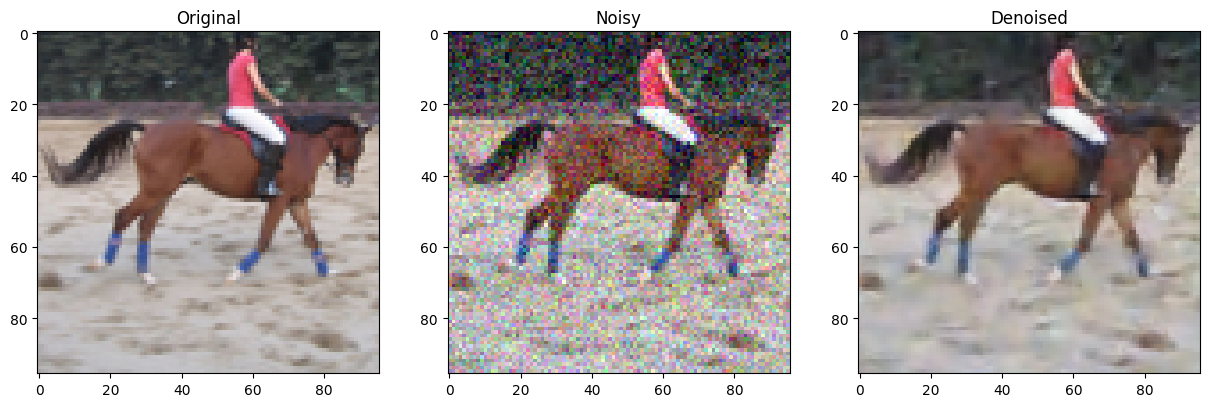

In [ ]:
# visualize the results.
visualize_results(model, test_loader)